# Find Polar Contacts

In [1]:
from biopandas.pdb import PandasPdb
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist

In [21]:
## Read in Experiments worksheet
experiments = pd.read_excel('../experiments.xlsx', sheet_name='HA1-docking')#.head(1)

## filter to where antibody_type is 'diffused'
experiments = experiments[experiments['antibody_type'] == 'diffused'].copy()

# experiments

In [3]:
def find_polar_contacts(pdb_path: str, chain1: str, chain2: str, cutoff=3.5):
    """
    Find polar contacts between two input chains in a PDB file using BioPandas.
    
    Parameters:
    pdb_path (str): Path to the PDB file.
    chain1 (str): Identifier for the first chain.
    chain2 (str): Identifier for the second chain.
    cutoff (float): Distance cutoff for identifying polar contacts.
    
    Returns:
    dict: A dictionary with chain identifiers as keys and lists of residue numbers involved in polar contacts as values.
    """
    ## Load PDB file
    ppdb = PandasPdb().read_pdb(pdb_path)
    df = ppdb.df['ATOM']

    ## Select polar atoms (N, O) from each chain
    polar_atoms_chain1 = df[(df['chain_id'] == chain1) & (df['element_symbol'].isin(['N', 'O']))]
    polar_atoms_chain2 = df[(df['chain_id'] == chain2) & (df['element_symbol'].isin(['N', 'O']))]

    ## Calculate pairwise distances between polar atoms
    distances = cdist(polar_atoms_chain1[['x_coord', 'y_coord', 'z_coord']].values, 
                      polar_atoms_chain2[['x_coord', 'y_coord', 'z_coord']].values)

    ## Find pairs of atoms within the distance cutoff
    pairs = np.argwhere(distances <= cutoff)

    ## Find corresponding residue numbers and names
    residue_numbers_chain1 = polar_atoms_chain1['residue_number'].values
    residue_numbers_chain2 = polar_atoms_chain2['residue_number'].values

    residue_names_chain1 = polar_atoms_chain1['residue_name'].values
    residue_names_chain2 = polar_atoms_chain2['residue_name'].values

    polar_contact_residues = []
    for pair in pairs:
        polar_contact_residues.append([
            residue_names_chain1[pair[0]],
            residue_numbers_chain1[pair[0]],
            residue_names_chain2[pair[1]],
            residue_numbers_chain2[pair[1]]
            ])

    ## Make polar contact residues a set
    polar_contact_residues = set(map(tuple, polar_contact_residues))

    ## Assemble dictionary
    polar_contact_residues_dict = {
        f"resn_chain{chain1}": [],
        f"resi_chain{chain1}": [],
        f"resn_chain{chain2}": [],
        f"resi_chain{chain2}": []
        }
    
    for pair in polar_contact_residues:
        polar_contact_residues_dict[f"resn_chain{chain1}"].append(pair[0])
        polar_contact_residues_dict[f"resi_chain{chain1}"].append(pair[1])
        polar_contact_residues_dict[f"resn_chain{chain2}"].append(pair[2])
        polar_contact_residues_dict[f"resi_chain{chain2}"].append(pair[3])

    ## Convert to dataframe
    polar_contact_residues_df = pd.DataFrame(polar_contact_residues_dict)

    return polar_contact_residues_df

In [39]:
## Define chains and cutoff
chain1 = "A"
chain2 = "B"
cutoff = 3

## Define start and end residues of HA1
resi_start = 1049
resi_end = 1322
residue_numbers = [f"pos_{i}" for i in range(resi_start, resi_end+1)]

## Make dataframe
positions = pd.DataFrame(columns=["antibody_id", "pdb_path"] + residue_numbers)

## Loop through experiments and get interfacing residues
for index, antibody in experiments.iterrows():
    antibody_id = antibody['antibody_id']
    pdb_path = f"../../experiments/{antibody_id}/4_docking/output/08_mdscoring/{antibody['best_model_name']}"

    print(f"Processing {pdb_path}")

    contacts = find_polar_contacts(pdb_path, chain1, chain2, cutoff)

    ## Fill with zeros
    positions.loc[index] = 0

    ## Fill with ones where there was a contact on the antigen (chain B)
    for pos in set(contacts["resi_chainB"].tolist()):
        positions.loc[index, f"pos_{pos}"] = 1

    positions.loc[index, "antibody_id"] = antibody_id
    positions.loc[index, "pdb_path"] = pdb_path

Processing ../../experiments/kinetic-template/4_docking/output/08_mdscoring/mdscoring_2.pdb
Processing ../../experiments/partial-lagoon/4_docking/output/08_mdscoring/mdscoring_2.pdb
Processing ../../experiments/glowing-avocet/4_docking/output/08_mdscoring/mdscoring_5.pdb
Processing ../../experiments/approximate-entrepreneur/4_docking/output/08_mdscoring/mdscoring_1.pdb
Processing ../../experiments/recursive-basin/4_docking/output/08_mdscoring/mdscoring_1.pdb
Processing ../../experiments/free-hearth/4_docking/output/08_mdscoring/mdscoring_1.pdb
Processing ../../experiments/smoky-latitude/4_docking/output/08_mdscoring/mdscoring_3.pdb
Processing ../../experiments/internal-rundown/4_docking/output/08_mdscoring/mdscoring_2.pdb
Processing ../../experiments/critical-tin/4_docking/output/08_mdscoring/mdscoring_2.pdb
Processing ../../experiments/gilded-stud/4_docking/output/08_mdscoring/mdscoring_3.pdb
Processing ../../experiments/concave-glove/4_docking/output/08_mdscoring/mdscoring_5.pdb
Proc

In [40]:
positions.to_csv("polar_contacts.csv", index=False)

-----------------
## PyMOL Highlighter

In [47]:
## Get sum of each column
positions_total = positions.drop(columns=["antibody_id", "pdb_path"]).sum(axis=0).to_dict()

## Shift experiment residues to match PDB
# resi_shift = -3

positions_total_shifted= {}
for key, value in positions_total.items():
    new_key = int(key.replace("pos_", "")) #+ resi_shift
    positions_total_shifted[new_key] = positions_total[key]

In [48]:
## Scale values from [0,1]
positions_shifted_scaled = {k: v / max(positions_total_shifted.values()) for k, v in positions_total_shifted.items()}

## Derive prevalence by number of experiments
n_experiments = len(experiments)
positions_shifted_prev = {k: v / n_experiments for k, v in positions_total_shifted.items()}

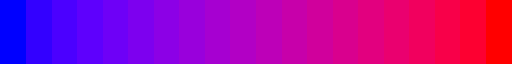

In [49]:
blue_to_red_colors = [
    '#0000ff',
    '#3300ff',
    '#4b00ff',
    '#5e00fd',
    '#6e00f7',
    '#7d00ef',
    '#8c00e6',
    '#9900dc',
    '#a600d1',
    '#b200c5',
    '#bd00b8',
    '#c700aa',
    '#d0009c',
    '#d9008e',
    '#e2007f',
    '#ea006f',
    '#f1005e',
    '#f80049',
    '#fd0031',
    '#ff0000'
]

## Show color scale with matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# fig, ax = plt.subplots(1, 1, figsize=(10, 1))
cmap = mcolors.ListedColormap(blue_to_red_colors)
cmap
# norm = mcolors.BoundaryNorm(list(positions_shifted_colors.keys()), cmap.N)
# cb1 = mcolors.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='horizontal')
# cb1.set_label('Residue position')
# plt.show()

In [50]:
## Convert to continuous hex color scale between blue and red
positions_shifted_colors = {k: blue_to_red_colors[int(v/(1/19))].replace("#", "0x") for k, v in positions_shifted_scaled.items()}

print(f"Min: {min(positions_shifted_colors.values())}\nMax: {max(positions_shifted_colors.values())}")
# positions_shifted_colors

Min: 0x0000ff
Max: 0xff0000


In [52]:
from pymol import cmd

ref_pdb_path = "../../data/inputs/EPI3009175_HA.pdb"

cmd.reinitialize("everything")
cmd.load(ref_pdb_path)

## Color residues 10-108 and 268-329 grey50
# cmd.color("grey50", "resi 10-108")
# cmd.color("grey50", "resi 268-329")


for pos, color in positions_shifted_colors.items():
    cmd.color(color, f"resi {pos-1000}")

## Save PyMOL session
cmd.save("polar_contacts.pse")


In [53]:
## Get sequence from PDB
ppdb = PandasPdb().read_pdb(ref_pdb_path)

## Extract residue names from the ATOM section
atom_df = ppdb.df['ATOM']

## Get the three-letter residue names in order of appearance (no duplicates per residue sequence number)
residues = atom_df[['residue_number', 'residue_name']].drop_duplicates()

## Convert to a list of residue names
residue_list = residues['residue_name'].tolist()

## Join as a comma-separated string
','.join(residue_list)

'LEU,GLU,LYS,THR,HIS,ASN,GLY,LYS,LEU,CYS,ASP,LEU,ASN,GLY,VAL,LYS,PRO,LEU,ILE,LEU,LYS,ASP,CYS,SER,VAL,ALA,GLY,TRP,LEU,LEU,GLY,ASN,PRO,LEU,CYS,ASP,GLU,PHE,ILE,ASN,VAL,PRO,GLU,TRP,SER,TYR,ILE,VAL,GLU,LYS,ALA,ASN,PRO,ALA,ASN,ASP,LEU,CYS,TYR,PRO,GLY,ASN,PHE,ASN,ASP,TYR,GLU,GLU,LEU,LYS,HIS,LEU,LEU,SER,ARG,ILE,ASN,HIS,PHE,GLU,LYS,ILE,GLN,ILE,ILE,PRO,LYS,ASN,SER,TRP,SER,ASP,HIS,GLU,ALA,SER,LEU,GLY,VAL,SER,ALA,GLY,CYS,SER,TYR,GLN,GLY,ASN,SER,SER,PHE,PHE,ARG,ASN,VAL,VAL,TRP,LEU,ILE,LYS,LYS,ASN,ASN,ALA,TYR,PRO,THR,ILE,LYS,LYS,ASP,TYR,ASN,ASN,THR,ASN,ARG,GLU,ASP,LEU,LEU,ILE,LEU,TRP,GLY,ILE,HIS,HIS,PRO,ASN,ASP,GLU,ALA,GLU,GLN,THR,LYS,LEU,TYR,GLN,ASN,PRO,THR,THR,TYR,ILE,SER,ILE,GLY,THR,SER,THR,LEU,ASN,GLN,ARG,LEU,VAL,PRO,LYS,ILE,ALA,THR,ARG,PRO,LYS,ILE,ASN,GLY,GLN,SER,GLY,ARG,ILE,ASP,PHE,PHE,TRP,THR,ILE,LEU,LYS,PRO,ASN,ASP,ALA,ILE,HIS,PHE,GLU,SER,ASN,GLY,ASN,PHE,ILE,ALA,PRO,GLU,TYR,ALA,TYR,LYS,ILE,VAL,LYS,LYS,GLY,ASP,SER,THR,ILE,MET,ARG,SER,GLU,ALA,GLN,TYR,GLY,ASN,CYS,ASN,THR,ARG,CYS,GLN,THR,PRO,ILE